In [1]:
# Mount your Google Drive.
# from google.colab import drive
# drive.mount("/content/drive")


In [2]:
!pip install mne
#


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [3]:
# import pandas as pd

# file_path = '/content/drive/MyDrive/Data/Sleep/SC-subjects.xls'

# # Read the .xls file
# data = pd.read_excel(file_path)

# # Print the data
# print(data)

In [4]:
import mne
import numpy as np

# # Specify the path to your .edf file
# file_path = '/content/drive/MyDrive/Data/Sleep/sleep_cassette/SC4001EC-Hypnogram.edf'

# # Read the .edf file
# raw = mne.read_annotations(file_path)
# print(raw.duration[:10])
# print(raw.description)
# Get durations for 'Sleep stage W'
# w_durations = raw.duration[raw.description == 'Sleep stage W']

# print(w_durations)




In [5]:

import matplotlib.pyplot as plt
import os
import numpy as np

%matplotlib inline

In [6]:
data_folder = "cass/"


In [7]:
!pip install mne


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [8]:
# !pip install librosa

import glob
import re
import os
import mne
mne.set_log_level('ERROR')
def fetch_patient_ids():
    # Construct the file path
    all_files = glob.glob(os.path.join(data_folder, 'SC*.edf'))

    # Regular expression pattern to match 'SC' followed by 4 digits
    pattern = re.compile(r'(SC\d{4})')

    # Extract patient IDs from file names
    patient_ids = [pattern.match(os.path.basename(file)).group(1) for file in all_files if pattern.match(os.path.basename(file))]

    # Get unique patient IDs
    unique_patient_ids = list(set(patient_ids))

    return unique_patient_ids
    # return [id for id in unique_patient_ids if id == 'SC4001']


In [9]:
# data = mne.io.read_raw_edf(os.path.join(data_folder, 'SC4001E0-PSG.edf'))
# X = data.get_data()[:2, :]

In [10]:
# ann = mne.read_annotations(os.path.join(data_folder, 'SC4001EC-Hypnogram.edf'))
# labels = []
# for dur, des in zip(ann.duration, ann.description):
#     for i in range(int(dur) // 30):
#         labels.append(des[-1])
# labels

In [11]:
print(len(fetch_patient_ids()))

153


In [12]:
import os
import mne
import glob

# def prepare_edf_files_for_classification(directory):
#     # List all files in the directory
#     files = os.listdir(directory)

#     # Filter out non-EDF files
#     edf_files = [file for file in files if file.endswith('PSG.edf')]

#     # Read and store all EDF files
#     edf_data = [mne.io.read_raw_edf(os.path.join(directory, file), preload=True) for file in edf_files]

#     # Prepare data for classification
#     # This is a placeholder - replace with your own preprocessing steps
#     # preprocessed_data = [prepare_for_classification(data) for data in edf_data]

#     return edf_data

EVENT_ID = {
  "Sleep stage W": 1,
  "Sleep stage 1": 2,
  "Sleep stage 2": 3,
  "Sleep stage SW": 4,
  "Sleep stage R": 5,
}

FREQ_BANDS = {
    "delta": [0.5, 4.5],
    "theta": [4.5, 8.5],
    "alpha": [8.5, 11.5],
    "sigma": [11.5, 15.5],
    "beta": [15.5, 30],
}

ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
  }

In [13]:
# from mne.datasets.sleep_physionet.age import fetch_data

# subjects = range(1)
# recordings = [1]

# fnames = fetch_data(subjects=subjects, recording=recordings, on_missing='warn')

In [14]:
import os
import glob

import glob
import os

def fetch_data(subject):
    """Fetches signal and annotation file paths for a given subject.

    Args:
        subject (str): Subject identifier.
        data_folder (str): Path to the data folder.

    Returns:
        dict: A dictionary containing 'subject', 'signal_file', and 'annotation_file' paths, or None if files are not found.
    """

    signal_file_pattern = os.path.join(data_folder, f"{subject}*PSG.edf")
    annotation_file_pattern = os.path.join(data_folder, f"{subject}*Hypnogram.edf")

    signal_files = glob.glob(signal_file_pattern)
    annotation_files = glob.glob(annotation_file_pattern)

    if not signal_files or not annotation_files:
        raise FileNotFoundError(f"Files not found for subject {subject}: {signal_file_pattern}, {annotation_file_pattern}")

    if len(signal_files) > 1 or len(annotation_files) > 1:
        print(f"Multiple files found for subject {subject}. Using first match.")

    return {
        'subject': subject,
        'signal_file': signal_files[0],
        'annotation_file': annotation_files[0],
    }



In [15]:
# a = fetch_data('SC4002')
# ann = mne.read_annotations(os.path.join(a['annotation_file']))
# labels = []
# for dur, des in zip(ann.duration, ann.description):
#     for i in range(int(dur) // 30):
#         labels.append(des[-1])
# labels

In [16]:
def load_data_refactored(subject, channel='Fpz-Cz', crop_wake_mins=30):


    # Fetch the data
    data = fetch_data(subject)
    if data is None:
        return None

    raw_fname = data['signal_file']
    annot_fname = data['annotation_file']

    raw = mne.io.read_raw_edf(
        raw_fname,
        infer_types=True,

    )

    # Select only the EEG channels Fpz-Cz and Pz-Oz
    raw.pick(['Fpz-Cz'])

    # Keep only the specified channel
    # raw.pick_channels([channel])

    annots = mne.read_annotations(annot_fname)
    raw.set_annotations(annots, emit_warning=True)

    if crop_wake_mins > 0:  # Cut start and end Wake periods
        # Find first and last sleep stages
        mask = [x[-1] in ['1', '2', '3', '4', 'R'] for x in annots.description]
        sleep_event_inds = np.where(mask)[0]

        # Crop raw
        tmin = max(0, annots[int(sleep_event_inds[0])]['onset'] - crop_wake_mins * 60)
        tmax = min(raw.times[-1], annots[int(sleep_event_inds[-1])]['onset'] + crop_wake_mins * 60)
        raw.crop(tmin=tmin, tmax=tmax)

    # Save subject and recording information in raw.info
    basename = os.path.basename(raw_fname)
    subj_nb, rec_nb = int(basename[3:5]), int(basename[5])
    raw.info['subject_info'] = {'id': subj_nb, 'rec_id': rec_nb}

    return raw



In [17]:
participant_id = 'SC4001'
# The training participant will be the one with ID 0 for now
raw_4001 = load_data_refactored(participant_id, 'Fpz-Cz')

In [18]:
sfreq = raw_4001.info['sfreq']
sfreq

100.0

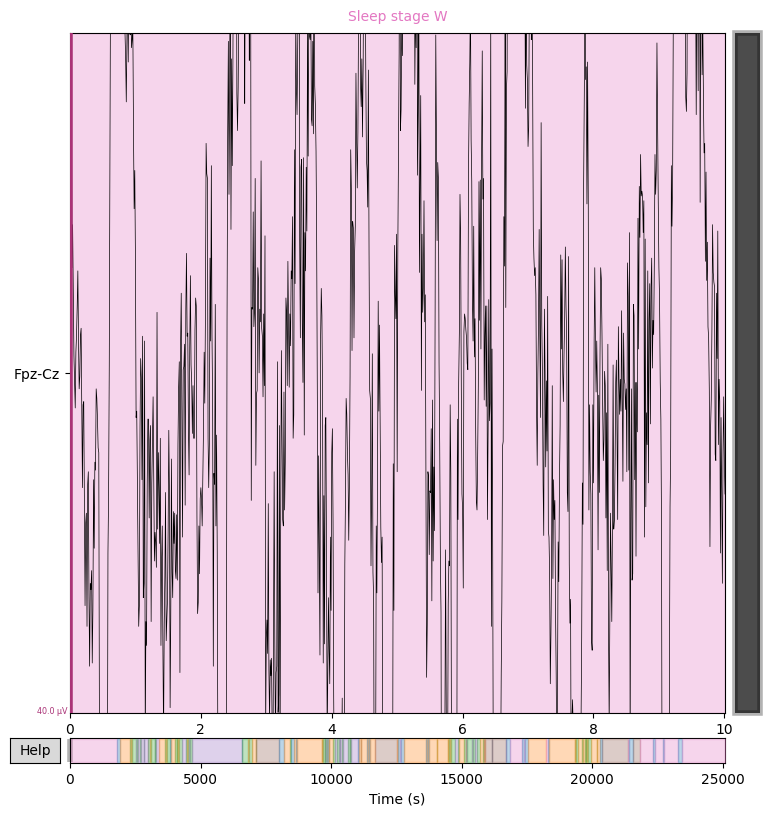

In [19]:
raw_4001.plot();

In [20]:
raws = [load_data_refactored(f, 'Fpz-Cz') for f in fetch_patient_ids()]

In [21]:
raws[0]

<RawEDF | SC4011E0-PSG.edf, 1 x 3261001 (32610.0 s), ~7 kB, data not loaded>

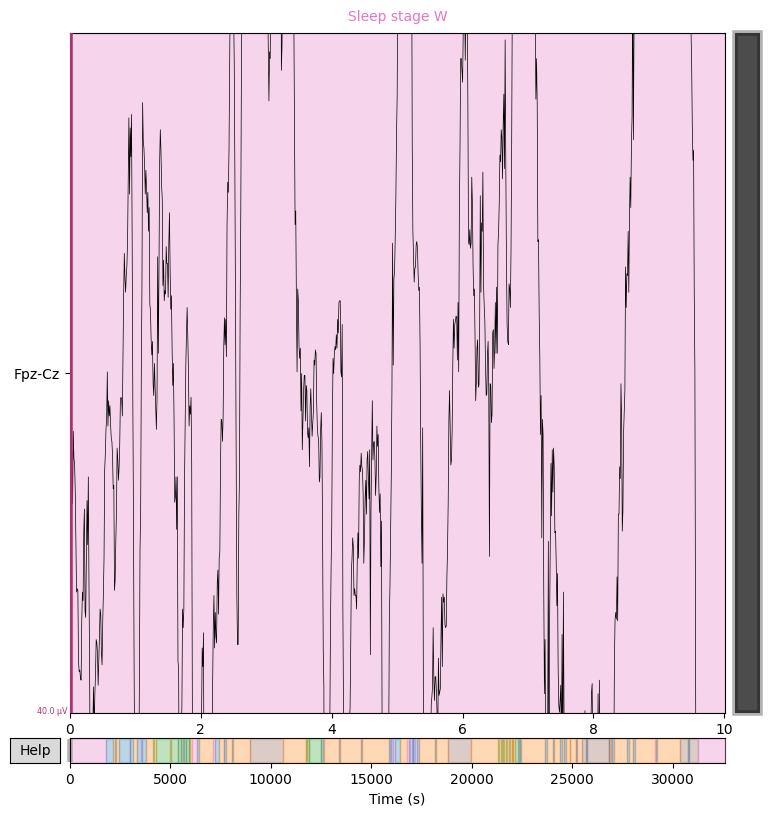

In [22]:
raws[0].plot();

In [23]:
l_freq, h_freq = None, 30

for raw in raws:
    raw.load_data().filter(l_freq, h_freq)

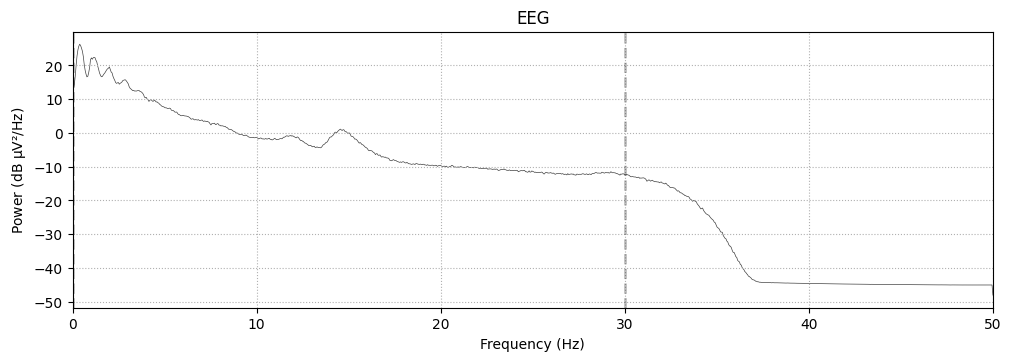

In [24]:
# Plot the power spectrum of a recording as sanity check
raws[0].plot_psd();

In [25]:
def extract_epochs(raw, chunk_duration=30.):

    events, _ = mne.events_from_annotations(
        raw, event_id=ANNOTATION_EVENT_ID, chunk_duration=30.0
    )


    tmax = 30. - 1. / raw.info['sfreq']  # tmax in included
    # Check if the events are in the event_id
    event_id = {k: v for k, v in EVENT_ID.items() if v in np.unique(events[:, 2])}

    picks = mne.pick_types(raw.info, eeg=True)
    epochs = mne.Epochs(
    raw=raw,
    events=events,
    event_id=event_id,
    tmin=0.0,
    tmax=tmax,
    baseline=None,
    preload=True,
    )
    # Get the epoch data and labels
    epochs_data = epochs.get_data()
    epochs_labels = epochs.events[:, 2] - 1

    return epochs, epochs_data, epochs_labels

In [26]:
epochs, epochs_data, epochs_labels = extract_epochs(raws[0])
# epochs_labels
import numpy as np

# Check if all elements are zero
if np.all(epochs_labels == 0):
    print("All elements are zero.")
else:
    print("Not all elements are zero.")

Not all elements are zero.


In [27]:
epochs_data.shape

(1087, 1, 3000)

In [28]:
unique_labels = np.unique(epochs_labels)
print("Unique numbers in epochs_labels:", unique_labels)


Unique numbers in epochs_labels: [0 1 2 3 4]


In [29]:
print(len(epochs_labels))

1087


In [30]:
print("Unique annotations in raw data:", np.unique(raws[0].annotations.description))
# print("Unique event IDs in events array:", np.unique(events[:, 2]))

Unique annotations in raw data: ['Sleep stage 1' 'Sleep stage 2' 'Sleep stage 3' 'Sleep stage 4'
 'Sleep stage R' 'Sleep stage W']


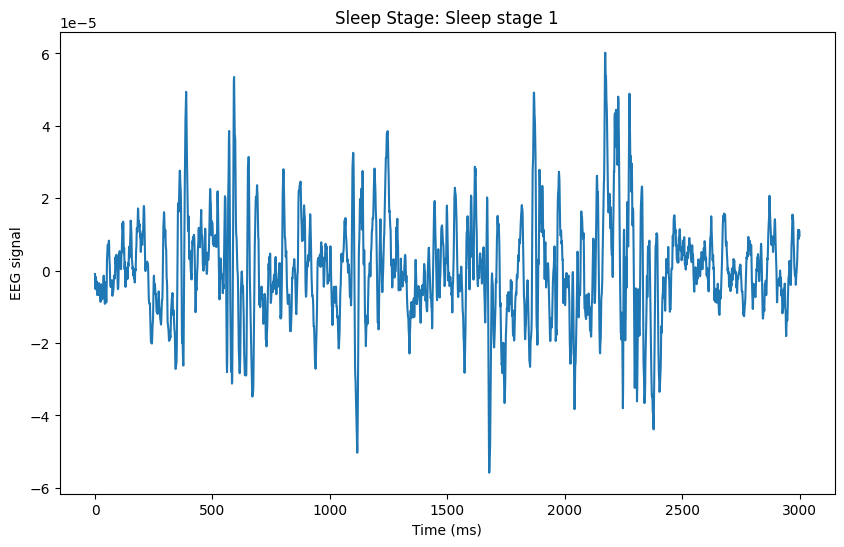

In [31]:
import matplotlib.pyplot as plt
import numpy as np

def plot_sleep_stage(epochs_data, epochs_labels, stage='Sleep stage 1'):
    # Find indices where sleep stage is 'R'
    indices = np.where(epochs_labels == ANNOTATION_EVENT_ID[stage])

    # Check if indices is empty
    if indices[0].size == 0:
        print(f"No epochs found for {stage}")
        return

    # Extract the corresponding data for the first epoch
    stage_data = epochs_data[indices][0]

    # Create a time array for the x-axis
    time = np.arange(epochs_data.shape[2])  # adjust this if your data's time points are not in milliseconds

    # Plot the data
    plt.figure(figsize=(10, 6))
    plt.plot(time, stage_data[0])  # plot data for the single channel
    plt.title(f"Sleep Stage: {stage}")
    plt.xlabel("Time (ms)")
    plt.ylabel("EEG signal")
    plt.show()

# Use the function
plot_sleep_stage(epochs_data, epochs_labels)


In [32]:
# def extract_consecutive_epochs(raw, chunk_duration=30.):
#     # Adjust the start time (tmin) to 30 seconds
#     tmin = 30.0
#     tmax = 60. - 1. / raw.info['sfreq']  # tmax is included

#     events, _ = mne.events_from_annotations(
#         raw, event_id=ANNOTATION_EVENT_ID, chunk_duration=chunk_duration
#     )

#     # Check if the events are in the event_id
#     event_id = {k: v for k, v in EVENT_ID.items() if v in np.unique(events[:, 2])}

#     epochs = mne.Epochs(
#         raw=raw,
#         events=events,
#         event_id=event_id,
#         tmin=tmin,
#         tmax=tmax,
#         baseline=None,
#         preload=True,
#     )
#     # Get the epoch data and labels
#     epochs_data = epochs.get_data()
#     epochs_labels = epochs.events[:, 2] - 1

#     return events, epochs_data, epochs_labels


In [33]:
_ ,a, b = extract_epochs(raws[0])
print("Length of epochs_data:", len(a))
print("Length of epochs_labels:", len(b))

Length of epochs_data: 1087
Length of epochs_labels: 1087


In [34]:
a

array([[[-1.74358974e-06, -2.99312452e-06, -4.45157274e-06, ...,
         -1.19034742e-05, -1.22201820e-05, -1.64901392e-05]],

       [[-1.42142200e-05, -8.26342645e-06, -7.91576829e-06, ...,
          1.49958487e-05,  1.42480418e-05,  1.23537052e-05]],

       [[ 1.36657478e-05,  1.75679829e-05,  1.94414350e-05, ...,
         -1.58314355e-06, -4.07422196e-06, -8.45574516e-06]],

       ...,

       [[-2.15152211e-05, -2.09167319e-05, -1.98954770e-05, ...,
          9.38980963e-05,  9.22736617e-05,  8.84291505e-05]],

       [[ 8.36748814e-05,  8.40181321e-05,  8.81306164e-05, ...,
         -3.50291323e-05, -3.26834261e-05, -3.00088781e-05]],

       [[-3.06695628e-05, -3.00132437e-05, -2.84269427e-05, ...,
         -1.98425818e-05, -1.98270092e-05, -2.21759665e-05]]])

In [35]:
events, epochs_data, epochs_labels = extract_epochs(raws[0])

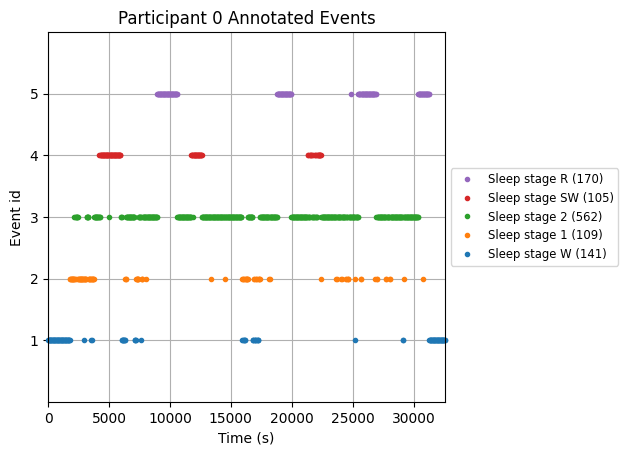

In [36]:
# plot events across time
fig = mne.viz.plot_events(
    epochs.events,
    event_id=EVENT_ID,
    sfreq=raws[0].info["sfreq"],
    first_samp=epochs.events[0, 0],
    show=False,
)
ax = fig.gca()

# Modify the plot a bit
ax.set_title("Participant 0 Annotated Events")

# keep the color-code for further plotting
stage_colors = plt.rcParams["axes.prop_cycle"].by_key()["color"]
plt.show()


In [37]:
from torch.utils.data import Dataset, ConcatDataset
import torch

class EpochsDataset(Dataset):
    def __init__(self, extra_var, epochs_data, epochs_labels, subj_nb=None, rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels), "Data and labels must have the same length"
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.extra_var = extra_var
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]

        if self.transform is not None:
            X = self.transform(X)
        X = torch.tensor(X, dtype=torch.float32)  # Ensure X is float32
        y = torch.tensor(y, dtype=torch.long)     # Ensure y is long
        return X, y



import numpy as np


def scale(X):
    X = np.asarray(X)

    if X.ndim == 3:
        mean = np.mean(X, axis=2, keepdims=True)
        std = np.std(X, axis=2, keepdims=True)
        std = np.where(std == 0, 1, std)
        X = (X - mean) / std
    elif X.ndim == 2:
        # Handle 2D data
        mean = np.mean(X, axis=1, keepdims=True)
        std = np.std(X, axis=1, keepdims=True)
        std = np.where(std == 0, 1, std)
        X = (X - mean) / std
    elif X.ndim == 1:
        # Handle 1D data
        mean = np.mean(X)
        std = np.std(X)
        std = np.where(std == 0, 1, std)
        X = (X - mean) / std
    else:
        raise ValueError("Unsupported data dimension")

    return X






In [38]:
import gc

def process_raw_file(raw, extract_func, transform_func):
    extra_var, epochs_data, epochs_labels = extract_func(raw)
    subj_nb = raw.info['subject_info']['id']
    rec_nb = raw.info['subject_info']['rec_id']
    return EpochsDataset(extra_var, epochs_data, epochs_labels, subj_nb=subj_nb, rec_nb=rec_nb, transform=transform_func)

# Assuming you have a list of raw objects as `raws`
all_datasets = []
for raw in raws:
    dataset_ = process_raw_file(raw, extract_epochs, scale)
    all_datasets.append(dataset_)
    del raw  # Free memory
    gc.collect()


In [39]:
dataset_30s = ConcatDataset(all_datasets)

In [40]:
a, b = dataset_30s[0]
a.shape

torch.Size([1, 3000])

In [41]:


def create_consecutive_30s_epochs(epochs_data, epochs_labels):
    for i in range(len(epochs_data) - 1):
        data_a = epochs_data[i]
        label_a = epochs_labels[i]
        data_b = epochs_data[i + 1]
        label_b = epochs_labels[i + 1]
        yield (data_a, data_b), (label_a, label_b)

def concatenate_and_filter_60s(consecutive_epochs_data):
    concatenated_data = []
    concatenated_labels = []

    for (data_a, data_b), (label_a, label_b) in consecutive_epochs_data:
        if label_a == label_b:  # Only keep if annotations match
            concatenated_segment = np.concatenate((data_a, data_b), axis=1)
            concatenated_data.append(concatenated_segment)
            concatenated_labels.append(label_a)  # Or label_b since they are the same

    return np.array(concatenated_data), np.array(concatenated_labels)

# Create the Dataset class for 60-second segments
class Epochs60sDataset(Dataset):
    def __init__(self, epochs_data, epochs_labels, subj_nb=None, rec_nb=None, transform=None):
        assert len(epochs_data) == len(epochs_labels), "Data and labels must have the same length"
        self.epochs_data = epochs_data
        self.epochs_labels = epochs_labels
        self.subj_nb = subj_nb
        self.rec_nb = rec_nb
        self.transform = transform

    def __len__(self):
        return len(self.epochs_labels)

    def __getitem__(self, idx):
        X, y = self.epochs_data[idx], self.epochs_labels[idx]

        if self.transform is not None:
            X = self.transform(X)
        X = torch.tensor(X, dtype=torch.float32)  # Ensure X is float32
        y = torch.tensor(y, dtype=torch.long)     # Ensure y is long
        return X, y

def scale2(X):
    X = np.asarray(X)
    mean = np.mean(X, axis=-1, keepdims=True)
    std = np.std(X, axis=-1, keepdims=True)
    std[std == 0] = 1
    return (X - mean) / std

# Function to process a single raw file and create a dataset
def process_raw_file(raw):
    _, epochs_data, epochs_labels = extract_epochs(raw)
    subj_nb = raw.info['subject_info']['id']
    rec_nb = raw.info['subject_info']['rec_id']
    consecutive_epochs_data = create_consecutive_30s_epochs(epochs_data, epochs_labels)
    concatenated_data, concatenated_labels = concatenate_and_filter_60s(consecutive_epochs_data)
    return Epochs60sDataset(concatenated_data, concatenated_labels, subj_nb=subj_nb, rec_nb=rec_nb, transform=scale2)

# Assuming you have a list of raw objects as `raws`
dataset_list = []
for raw in raws:
    dataset_ = process_raw_file(raw)
    dataset_list.append(dataset_)
    del raw  # Free memory
    gc.collect()

# Create a concatenated dataset
concatenated_dataset = ConcatDataset(dataset_list)


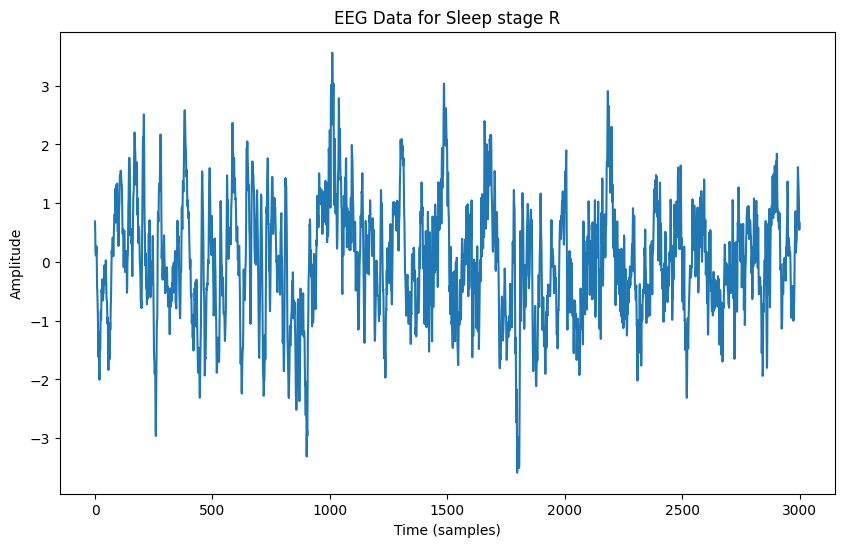

In [42]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Define constants for the stages
ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}
SLEEP_STAGE_ID = {v: k for k, v in ANNOTATION_EVENT_ID.items()}

# Create a DataLoader
dataloader = DataLoader(dataset_30s, batch_size=1, shuffle=False)

def plot_sleep_stage(dataloader, stage='Sleep stage R', channel=0):
    """
    Plot the data for a specific sleep stage.

    Parameters:
    - dataloader: DataLoader object containing the dataset
    - stage: Sleep stage to filter and plot (default is 'Sleep stage R')
    - channel: The EEG channel to plot (default is 0)
    """
    stage_id = ANNOTATION_EVENT_ID[stage] - 1  # Adjust for label correction
    stage_data = []

    for X, y in dataloader:
        if y.item() == stage_id:
            stage_data.append(X.numpy())

    if not stage_data:
        print(f"No epochs found for {stage}")
        return

    # Plot the data for the first epoch of the specified stage
    epoch_data = stage_data[0][0, channel, :]
    time = np.arange(epoch_data.shape[0])  # Assuming the time points are in samples

    plt.figure(figsize=(10, 6))
    plt.plot(time, epoch_data)  # Plot data for the specified channel
    plt.title(f"EEG Data for {stage}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

# Use the function to plot data for "Sleep stage R"
plot_sleep_stage(dataloader, stage='Sleep stage R', channel=0)




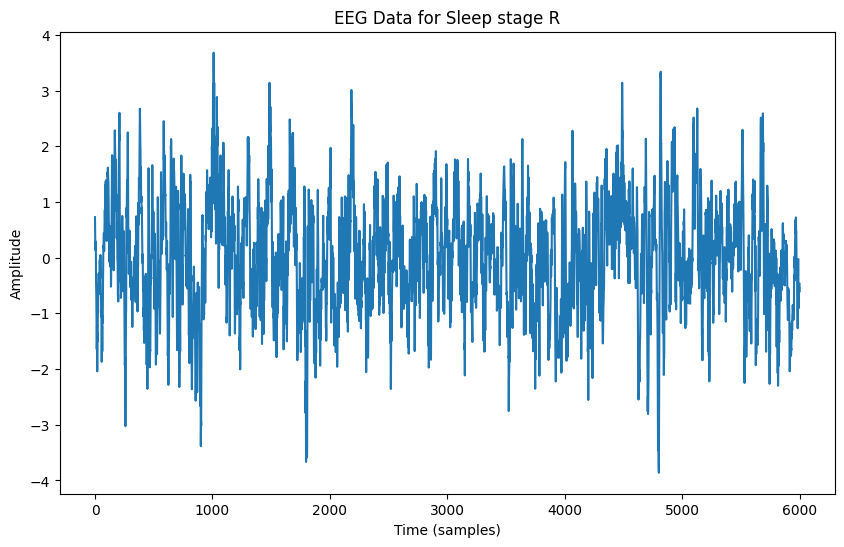

In [43]:
import matplotlib.pyplot as plt
import numpy as np
from torch.utils.data import DataLoader

# Define constants for the stages
ANNOTATION_EVENT_ID = {
    "Sleep stage W": 1,
    "Sleep stage 1": 2,
    "Sleep stage 2": 3,
    "Sleep stage 3": 4,
    "Sleep stage 4": 4,
    "Sleep stage R": 5,
}
SLEEP_STAGE_ID = {v: k for k, v in ANNOTATION_EVENT_ID.items()}

# Create a DataLoader
dataloader = DataLoader(concatenated_dataset, batch_size=1, shuffle=False)

def plot_sleep_stage(dataloader, stage='Sleep stage R', channel=0):
    """
    Plot the data for a specific sleep stage.

    Parameters:
    - dataloader: DataLoader object containing the dataset
    - stage: Sleep stage to filter and plot (default is 'Sleep stage R')
    - channel: The EEG channel to plot (default is 0)
    """
    stage_id = ANNOTATION_EVENT_ID[stage] - 1  # Adjust for label correction
    stage_data = []

    for X, y in dataloader:
        if y.item() == stage_id:
            stage_data.append(X.numpy())

    if not stage_data:
        print(f"No epochs found for {stage}")
        return

    # Plot the data for the first epoch of the specified stage
    epoch_data = stage_data[0][0, channel, :]
    time = np.arange(epoch_data.shape[0])  # Assuming the time points are in samples

    plt.figure(figsize=(10, 6))
    plt.plot(time, epoch_data)  # Plot data for the specified channel
    plt.title(f"EEG Data for {stage}")
    plt.xlabel("Time (samples)")
    plt.ylabel("Amplitude")
    plt.show()

# Use the function to plot data for "Sleep stage R"
plot_sleep_stage(dataloader, stage='Sleep stage R', channel=0)

Sleep stage counts in dataset_30s:
Stage 0: 64771
Stage 1: 21522
Stage 2: 69132
Stage 3: 13039
Stage 4: 25835


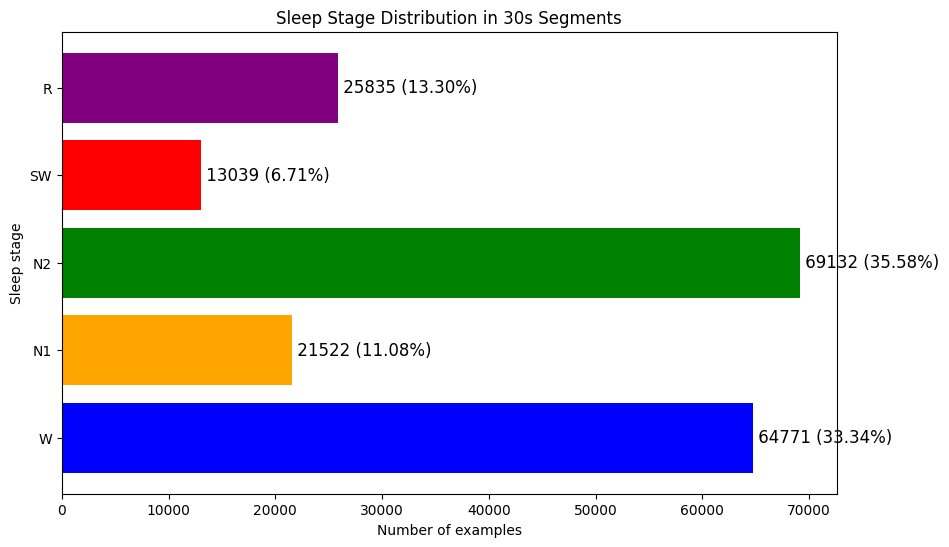

In [44]:
import matplotlib.pyplot as plt
from collections import Counter
import pandas as pd

# Function to count sleep stages
def count_sleep_stages(dataset):
    all_labels = []
    for ds in dataset.datasets:
        all_labels.extend(ds.epochs_labels)
    stage_counts = Counter(all_labels)
    return stage_counts

# Function to create color table with percentages
def create_color_table_with_percentage(stage_counts, title='Sleep Stage Distribution'):
    stages = ['W', 'N1', 'N2', 'SW', 'R']
    colors = ['blue', 'orange', 'green', 'red', 'purple']
    total_count = sum(stage_counts.values())
    counts = [stage_counts.get(i, 0) for i in range(len(stages))]
    percentages = [(count / total_count) * 100 for count in counts]

    df = pd.DataFrame({'Stage': stages, 'Count': counts, 'Percentage': percentages, 'Color': colors})
    fig, ax = plt.subplots(figsize=(10, 6))

    bars = ax.barh(df['Stage'], df['Count'], color=df['Color'])
    for i, bar in enumerate(bars):
        ax.text(bar.get_width(), bar.get_y() + bar.get_height()/2,
                f" {df['Count'][i]} ({df['Percentage'][i]:.2f}%)",
                va='center', color='black', fontsize=12)

    ax.set_xlabel('Number of examples')
    ax.set_ylabel('Sleep stage')
    ax.set_title(title)
    plt.show()

# Get counts of each sleep stage in dataset_30s
stage_counts_30s = count_sleep_stages(dataset_30s)

# Print the counts
print("Sleep stage counts in dataset_30s:")
for stage, count in stage_counts_30s.items():
    print(f"Stage {stage}: {count}")

# Create color table with percentages
create_color_table_with_percentage(stage_counts_30s, title='Sleep Stage Distribution in 30s Segments')



Sleep stage counts in dataset_30s:
Stage 0: 61077
Stage 1: 15585
Stage 2: 62791
Stage 3: 10380
Stage 4: 24310


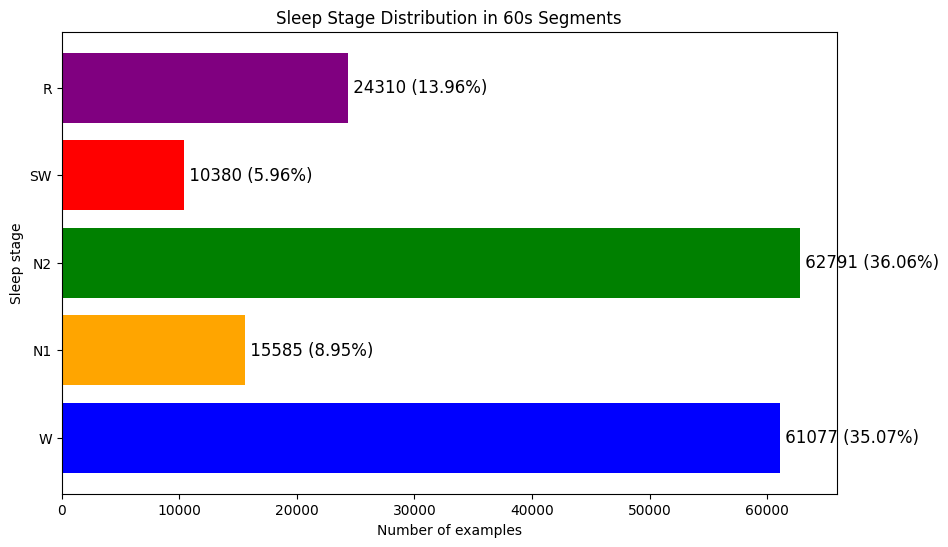

In [45]:


# Get counts of each sleep stage in dataset_30s
stage_counts_60s = count_sleep_stages(concatenated_dataset)

# Print the counts
print("Sleep stage counts in dataset_30s:")
for stage, count in stage_counts_60s.items():
    print(f"Stage {stage}: {count}")

# Create color table with percentages
create_color_table_with_percentage(stage_counts_60s, title='Sleep Stage Distribution in 60s Segments')



In [46]:

# Assuming dataset_30s and dataset_60s are your 30-second and 60-second datasets respectively
print(f"Number of data points in 30-s dataset: {len(dataset_30s)}")
print(f"Number of data points in 60-s dataset: {len(concatenated_dataset)}")



Number of data points in 30-s dataset: 194299
Number of data points in 60-s dataset: 174143


In [47]:
from sklearn.model_selection import LeavePGroupsOut
from sklearn.utils.class_weight import compute_class_weight


class DatasetManager:
    def __init__(self, dataset):
        self.dataset = dataset

    def pick_recordings(self, subj_rec_nbs):
        pick_idx = [i for i, ds in enumerate(self.dataset.datasets) if (ds.subj_nb, ds.rec_nb) in subj_rec_nbs]
        remaining_idx = np.setdiff1d(range(len(self.dataset.datasets)), pick_idx)

        pick_ds = ConcatDataset([self.dataset.datasets[i] for i in pick_idx])
        remaining_ds = ConcatDataset([self.dataset.datasets[i] for i in remaining_idx]) if len(remaining_idx) > 0 else None
        return pick_ds, remaining_ds

    def train_test_split(self, n_groups, split_by='subj_nb'):
        groups = [getattr(ds, split_by) for ds in self.dataset.datasets]
        train_idx, test_idx = next(LeavePGroupsOut(n_groups).split(X=np.zeros(len(groups)), groups=groups))
        train_ds = ConcatDataset([self.dataset.datasets[i] for i in train_idx])
        test_ds = ConcatDataset([self.dataset.datasets[i] for i in test_idx])
        return train_ds, test_ds

    def compute_class_weights(self, train_ds):
        train_y = np.concatenate([ds.epochs_labels for ds in train_ds.datasets])
        class_weights = compute_class_weight('balanced', classes=np.unique(train_y), y=train_y)
        return class_weights

    def plot_class_distribution(self, dataset, title='Class Distribution'):
        classes_mapping = {0: 'W', 1: 'N1', 2: 'N2', 3: 'SW', 4: 'R'}
        y_data = pd.Series([int(y.item()) for _, y in dataset])  # Convert tensors to integers
        print("Labels before mapping:", y_data.unique())
        
        y_data = y_data.map(classes_mapping)
        print("Labels after mapping:", y_data.unique())
        
        ax = y_data.value_counts().plot(kind='barh')
        ax.set_xlabel('Number of examples')
        ax.set_ylabel('Sleep stage')
        ax.set_title(title)
        plt.show()
       

In [48]:
!pip install seaborn


[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: pip install --upgrade pip


[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1)]
Labels before mapping: [0 1 2 3 4]
Labels after mapping: ['W' 'N1' 'N2' 'SW' 'R']


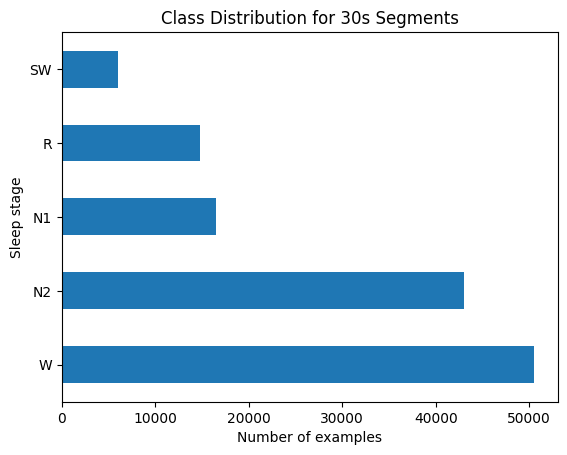

Labels before mapping: [0 1 2 3 4]
Labels after mapping: ['W' 'N1' 'N2' 'SW' 'R']


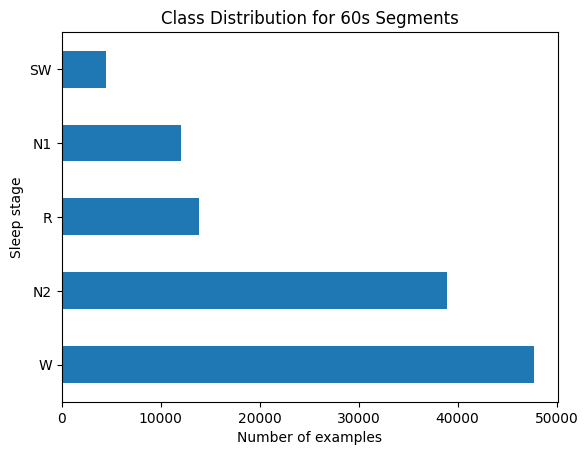

Class Weights for 30s segments: [0.5182565  1.58658344 0.6087375  4.33186631 1.76498584]
Class Weights for 60s segments: [0.49054801 1.93879781 0.6014795  5.20952169 1.69159864]


In [49]:
import pandas as pd
import seaborn as sn
# Initialize dataset managers
dataset_manager_30s = DatasetManager(dataset_30s)
dataset_manager_60s = DatasetManager(concatenated_dataset)

# Pick test recordings
test_recs = [(subj_nb, rec_nb) for subj_nb, rec_nb in zip(range(8), [1] * 8)]
print(test_recs)
test_ds_30s, train_ds_30s = dataset_manager_30s.pick_recordings(test_recs)
test_ds_60s, train_ds_60s = dataset_manager_60s.pick_recordings(test_recs)

# Split remaining data into training and validation sets
n_subjects_valid_30s = max(1, int(len(train_ds_30s.datasets) * 0.2))
train_ds_30s, valid_ds_30s = dataset_manager_30s.train_test_split(n_subjects_valid_30s, split_by='subj_nb')

n_subjects_valid_60s = max(1, int(len(train_ds_60s.datasets) * 0.2))
train_ds_60s, valid_ds_60s = dataset_manager_60s.train_test_split(n_subjects_valid_60s, split_by='subj_nb')

# Plot class distribution for training datasets
dataset_manager_30s.plot_class_distribution(train_ds_30s, title='Class Distribution for 30s Segments')
dataset_manager_60s.plot_class_distribution(train_ds_60s, title='Class Distribution for 60s Segments')

# Compute class weights
class_weights_30s = dataset_manager_30s.compute_class_weights(train_ds_30s)
class_weights_60s = dataset_manager_60s.compute_class_weights(train_ds_60s)

print("Class Weights for 30s segments:", class_weights_30s)
print("Class Weights for 60s segments:", class_weights_60s)

In [50]:
print(len(train_ds_30s), len(valid_ds_30s), len(test_ds_30s))

130909 63390 7593


In [51]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns

# Check for GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

class AccuracyEarlyStopping:
    def __init__(self, patience=5, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.best_val_accuracy = 0
        self.counter = 0
        self.early_stop = False

    def __call__(self, train_accuracy, val_accuracy):
        if train_accuracy > val_accuracy:
            self.best_val_accuracy = val_accuracy
            self.counter = 0
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True


Using device: cuda


In [52]:
# Model definition
class CustomModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv1d(1, 64, kernel_size=5, stride=3)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=5, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.4)

        self.conv3 = nn.Conv1d(128, 128, kernel_size=13, stride=1)
        self.conv4 = nn.Conv1d(128, 256, kernel_size=7, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv1d(256, 256, kernel_size=7, stride=1)
        self.conv6 = nn.Conv1d(256, 64, kernel_size=4, stride=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv1d(64, 32, kernel_size=3, stride=1)
        self.conv8 = nn.Conv1d(32, 64, kernel_size=6, stride=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv9 = nn.Conv1d(64, 8, kernel_size=5, stride=1)
        self.conv10 = nn.Conv1d(8, 8, kernel_size=2, stride=1)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self._calculate_flattened_size(input_size), 64)
        self.dropout2 = nn.Dropout(0.4)
        self.fc2 = nn.Linear(64, num_classes)

    def _calculate_flattened_size(self, input_size):
        x = torch.zeros(1, 1, input_size)
        x = self.pool1(self.conv2(self.conv1(x)))
        x = self.pool2(self.conv4(self.conv3(self.dropout1(x))))
        x = self.pool3(self.conv6(self.conv5(x)))
        x = self.pool4(self.conv8(self.conv7(x)))
        x = self.pool5(self.conv10(self.conv9(x)))
        return x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool4(x)

        x = F.relu(self.conv9(x))
        x = F.relu(self.conv10(x))
        x = self.pool5(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x


In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class RandomModel(nn.Module):
    def __init__(self, input_size, num_classes):
        super(RandomModel, self).__init__()
        self.conv1 = nn.Conv1d(1, 128, kernel_size=3, stride=3)
        self.conv2 = nn.Conv1d(128, 152, kernel_size=3, stride=1)
        self.pool1 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.dropout1 = nn.Dropout(0.6)

        self.conv3 = nn.Conv1d(152, 232, kernel_size=9, stride=1)
        self.conv4 = nn.Conv1d(232, 56, kernel_size=9, stride=1)
        self.pool2 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv5 = nn.Conv1d(56, 240, kernel_size=5, stride=1)
        self.conv6 = nn.Conv1d(240, 64, kernel_size=4, stride=1)
        self.pool3 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.conv7 = nn.Conv1d(64, 48, kernel_size=11, stride=1)
        self.conv8 = nn.Conv1d(48, 200, kernel_size=9, stride=1)
        self.pool4 = nn.MaxPool1d(kernel_size=2, stride=2)
        self.pool5 = nn.MaxPool1d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(self._calculate_flattened_size(input_size), 88)
        self.dropout2 = nn.Dropout(0.6)
        self.fc2 = nn.Linear(88, num_classes)

    def _calculate_flattened_size(self, input_size):
        x = torch.zeros(1, 1, input_size)
        x = self.pool1(self.conv2(self.conv1(x)))
        x = self.pool2(self.conv4(self.conv3(self.dropout1(x))))
        x = self.pool3(self.conv6(self.conv5(x)))
        x = self.pool4(self.conv8(self.conv7(x)))
        x = self.pool5(x)
        return x.numel()

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = self.pool1(x)
        x = self.dropout1(x)

        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool2(x)

        x = F.relu(self.conv5(x))
        x = F.relu(self.conv6(x))
        x = self.pool3(x)

        x = F.relu(self.conv7(x))
        x = F.relu(self.conv8(x))
        x = self.pool4(x)
        x = self.pool5(x)

        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)

        return x

# Example usage:
# model = CustomCNN()
# print(model)


In [54]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, test_loader, criterion, optimizer, class_weights=None, num_epochs=12, patience=10):
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.test_loader = test_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.num_epochs = num_epochs
        self.early_stopping = AccuracyEarlyStopping(patience=patience, verbose=True)
        self.class_weights = class_weights

    def train(self):
        train_acc_list = []
        val_acc_list = []

        for epoch in range(self.num_epochs):
            running_loss = 0.0
            correct = 0
            total = 0
            self.model.train()
            for data in self.train_loader:
                inputs, labels = data
                # print(inputs, labels)
                inputs, labels = inputs.to(device).float(), labels.to(device).long()

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                # print(f"Outputs dtype: {outputs.dtype}, labels dtype: {labels.dtype}")

                loss = self.criterion(outputs, labels)
                loss.backward()
                self.optimizer.step()

                running_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

            train_accuracy = 100 * correct / total
            val_loss, val_accuracy = self.validate()
            train_acc_list.append(train_accuracy)
            val_acc_list.append(val_accuracy)

            print(f"Epoch {epoch+1}, Loss: {running_loss/len(self.train_loader)}, Train Accuracy: {train_accuracy:.2f}%, Val Loss: {val_loss}, Val Accuracy: {val_accuracy:.2f}%")

            self.early_stopping(train_accuracy, val_accuracy)
            if self.early_stopping.early_stop:
                print("Early stopping")
                break

        print("Finished Training")
        self.plot_accuracy_curve(train_acc_list, val_acc_list)


    def validate(self):
        self.model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        with torch.no_grad():
            for data in self.val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device).float(), labels.to(device).long()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        return val_loss / len(self.val_loader), accuracy

    def test(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in self.test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device).float(), labels.to(device).long()

                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Test Accuracy: {accuracy:.2f}%")
        return accuracy

    def plot_confusion_matrix(self):
        self.model.eval()
        all_preds = []
        all_labels = []
        with torch.no_grad():
            for data in self.test_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device).float(), labels.to(device)

                outputs = self.model(inputs)
                _, predicted = torch.max(outputs.data, 1)
                all_preds.extend(predicted.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())

        cm = confusion_matrix(all_labels, all_preds)
        plt.figure(figsize=(10,7))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.ylabel('Actual')
        plt.xlabel('Predicted')
        plt.show()

    def plot_accuracy_curve(self, train_acc, val_acc):
        plt.plot(train_acc, label='Training Accuracy')
        plt.plot(val_acc, label='Validation Accuracy')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()
        plt.show()

Epoch 1, Loss: 1.2587570799749133, Train Accuracy: 51.22%, Val Loss: 0.8455226154449728, Val Accuracy: 65.46%
Epoch 2, Loss: 0.873218525289411, Train Accuracy: 65.99%, Val Loss: 0.7335804883444039, Val Accuracy: 69.41%
Epoch 3, Loss: 0.8078156240963755, Train Accuracy: 69.35%, Val Loss: 0.7109547411445145, Val Accuracy: 74.78%
Epoch 4, Loss: 0.7781069606316757, Train Accuracy: 70.16%, Val Loss: 0.6655580891713295, Val Accuracy: 73.41%
Epoch 5, Loss: 0.7571273920982456, Train Accuracy: 71.06%, Val Loss: 0.61803476172518, Val Accuracy: 76.97%
Epoch 6, Loss: 0.7399942293213154, Train Accuracy: 71.61%, Val Loss: 0.6366012729653928, Val Accuracy: 73.03%
Epoch 7, Loss: 0.7249963866035445, Train Accuracy: 72.01%, Val Loss: 0.6789866727453926, Val Accuracy: 73.29%
Epoch 8, Loss: 0.7136685417373616, Train Accuracy: 72.12%, Val Loss: 0.6058670562998172, Val Accuracy: 76.68%
Epoch 9, Loss: 0.7025686266391092, Train Accuracy: 72.69%, Val Loss: 0.6288814626425985, Val Accuracy: 77.51%
Epoch 10, Los

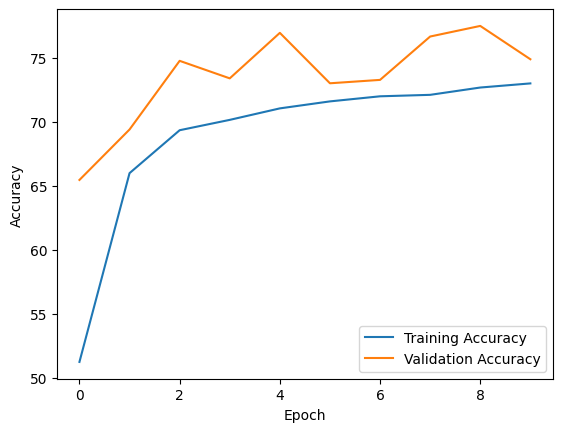

In [55]:
# Example usage
def get_data_loaders(train_ds, val_ds, test_ds, batch_size=32):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

input_size = 3000  # Example input size
num_classes = 5  # Example number of classes

model = CustomModel(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_30s).to(device).float() if class_weights_30s is not None else None)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loader_30s, val_loader_30s, test_loader_30s = get_data_loaders(train_ds_30s, valid_ds_30s, test_ds_30s)
trainer_30s = Trainer(model, train_loader_30s, val_loader_30s, test_loader_30s, criterion, optimizer)
trainer_30s.train()


Test Accuracy: 74.49%


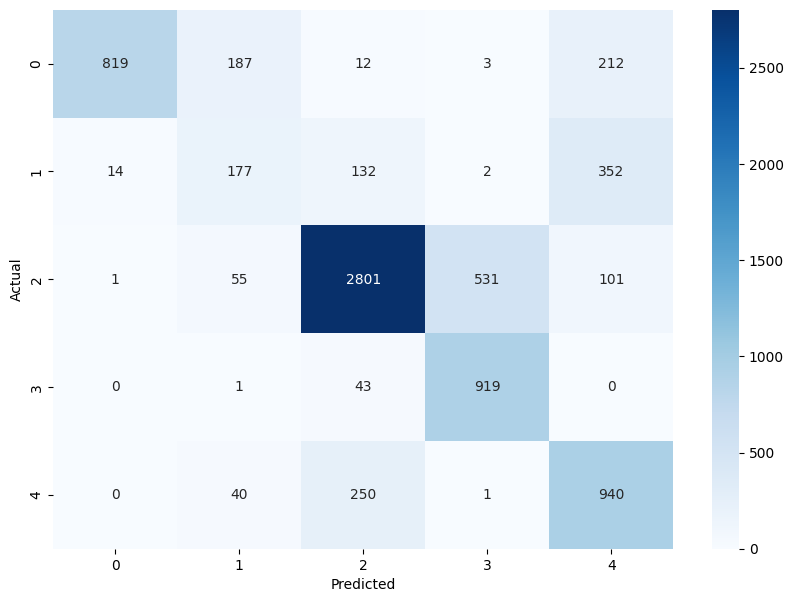

In [56]:
trainer_30s.test()
trainer_30s.plot_confusion_matrix()

Epoch 1, Loss: 1.057949857230915, Train Accuracy: 57.74%, Val Loss: 0.9135841176665297, Val Accuracy: 58.05%
Epoch 2, Loss: 0.812594073746953, Train Accuracy: 70.83%, Val Loss: 0.7676319494041586, Val Accuracy: 69.91%
Epoch 3, Loss: 0.7472011309710641, Train Accuracy: 73.24%, Val Loss: 0.5942902197352392, Val Accuracy: 79.60%
Epoch 4, Loss: 0.6973082650942567, Train Accuracy: 75.23%, Val Loss: 0.6072292996750628, Val Accuracy: 80.21%
Epoch 5, Loss: 0.6564952677864623, Train Accuracy: 76.76%, Val Loss: 0.5655286160964184, Val Accuracy: 77.82%
Epoch 6, Loss: 0.6304557635040353, Train Accuracy: 77.66%, Val Loss: 0.5187904684981276, Val Accuracy: 80.85%
Epoch 7, Loss: 0.6064703196743272, Train Accuracy: 78.34%, Val Loss: 0.5165543809882885, Val Accuracy: 80.44%
Epoch 8, Loss: 0.5885930621874857, Train Accuracy: 78.99%, Val Loss: 0.5183565398495411, Val Accuracy: 78.21%
Epoch 9, Loss: 0.5709110464056713, Train Accuracy: 79.30%, Val Loss: 0.5327061952005281, Val Accuracy: 79.06%
Epoch 10, Lo

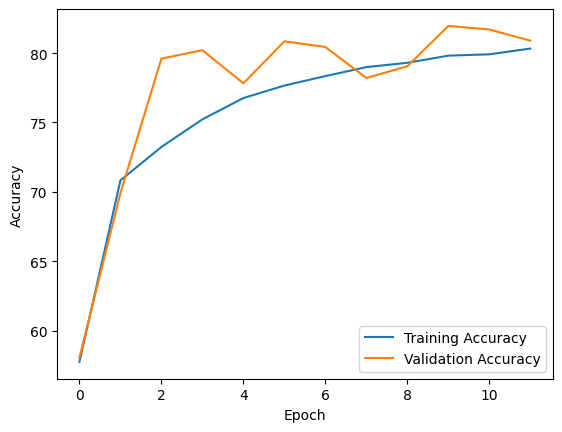

In [57]:
def get_data_loaders(train_ds, val_ds, test_ds, batch_size=32):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

input_size = 6000  # Assuming input size for 60s segments is 6000
num_classes = 5  # Example number of classes

model_60s = CustomModel(input_size=input_size, num_classes=num_classes)
criterion_60s = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_60s).to(device).float() if class_weights_60s is not None else None)
optimizer_60s = optim.Adam(model_60s.parameters(), lr=0.0001)

train_loader_60s, val_loader_60s, test_loader_60s = get_data_loaders(train_ds_60s, valid_ds_60s, test_ds_60s)
trainer_60s = Trainer(model_60s, train_loader_60s, val_loader_60s, test_loader_60s, criterion_60s, optimizer_60s)
trainer_60s.train()



Test Accuracy: 81.75%


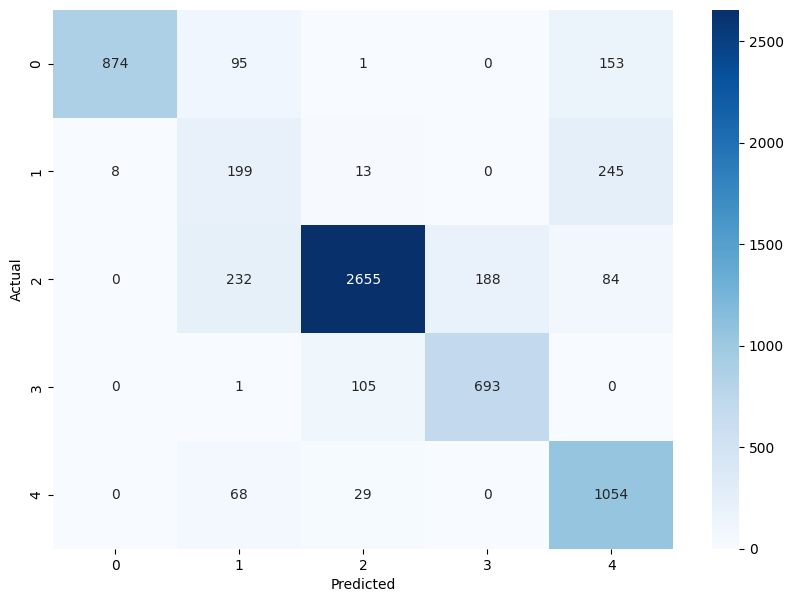

In [58]:
trainer_60s.test()
trainer_60s.plot_confusion_matrix()

Epoch 1, Loss: 1.094542060642014, Train Accuracy: 53.82%, Val Loss: 0.8095933913876336, Val Accuracy: 67.44%
Epoch 2, Loss: 0.8911590760260041, Train Accuracy: 64.17%, Val Loss: 0.6820517381889059, Val Accuracy: 72.06%
Epoch 3, Loss: 0.8313634496494541, Train Accuracy: 67.31%, Val Loss: 0.6606077642164379, Val Accuracy: 74.64%
Epoch 4, Loss: 0.7980183044758556, Train Accuracy: 68.88%, Val Loss: 0.6398411668135388, Val Accuracy: 77.18%
Epoch 5, Loss: 0.7747850703365556, Train Accuracy: 69.87%, Val Loss: 0.6272602410086328, Val Accuracy: 75.96%
Epoch 6, Loss: 0.7503261386226308, Train Accuracy: 70.59%, Val Loss: 0.6058086964293984, Val Accuracy: 76.31%
Epoch 7, Loss: 0.7285280615069469, Train Accuracy: 71.37%, Val Loss: 0.6678951955718532, Val Accuracy: 70.15%
Epoch 8, Loss: 0.7113158295117273, Train Accuracy: 71.92%, Val Loss: 0.5780084164229319, Val Accuracy: 76.54%
Epoch 9, Loss: 0.7041853283923752, Train Accuracy: 72.29%, Val Loss: 0.6046245414934515, Val Accuracy: 73.53%
Epoch 10, L

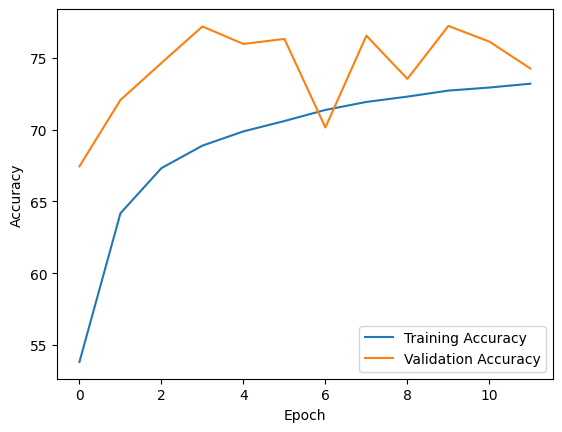

In [59]:
def get_data_loaders(train_ds, val_ds, test_ds, batch_size=32):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

input_size = 3000  # Example input size
num_classes = 5  # Example number of classes

model = RandomModel(input_size=input_size, num_classes=num_classes)
criterion = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_30s).to(device).float() if class_weights_30s is not None else None)
optimizer = optim.Adam(model.parameters(), lr=0.0001)

train_loader_30s, val_loader_30s, test_loader_30s = get_data_loaders(train_ds_30s, valid_ds_30s, test_ds_30s)
trainer_30s = Trainer(model, train_loader_30s, val_loader_30s, test_loader_30s, criterion, optimizer)
trainer_30s.train()

Test Accuracy: 75.93%


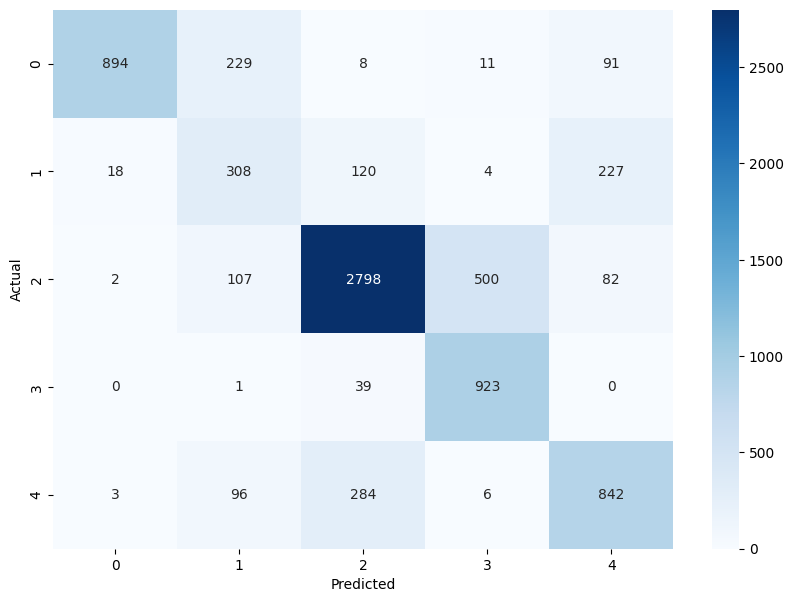

In [60]:
trainer_30s.test()
trainer_30s.plot_confusion_matrix()

Epoch 1, Loss: 1.047670152310173, Train Accuracy: 56.60%, Val Loss: 0.685849338525915, Val Accuracy: 73.66%
Epoch 2, Loss: 0.7640182734040752, Train Accuracy: 71.63%, Val Loss: 0.5772276497964189, Val Accuracy: 77.74%
Epoch 3, Loss: 0.6946324602148187, Train Accuracy: 74.57%, Val Loss: 0.5130208836970127, Val Accuracy: 79.66%
Epoch 4, Loss: 0.6619108877536475, Train Accuracy: 75.61%, Val Loss: 0.4824531675135418, Val Accuracy: 81.91%
Epoch 5, Loss: 0.6362185421969663, Train Accuracy: 76.63%, Val Loss: 0.4780169623786265, Val Accuracy: 83.39%
Epoch 6, Loss: 0.6130457872753425, Train Accuracy: 77.35%, Val Loss: 0.5159702215805037, Val Accuracy: 80.35%
Epoch 7, Loss: 0.5949611150931713, Train Accuracy: 78.06%, Val Loss: 0.5246478345467139, Val Accuracy: 81.69%
Epoch 8, Loss: 0.584772224401346, Train Accuracy: 78.42%, Val Loss: 0.4667239342209467, Val Accuracy: 82.67%
Epoch 9, Loss: 0.5686400221423002, Train Accuracy: 79.09%, Val Loss: 0.47215894927366464, Val Accuracy: 82.17%
Epoch 10, Lo

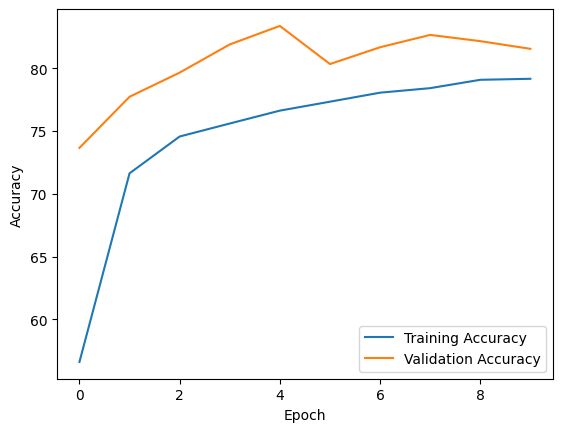

In [61]:
def get_data_loaders(train_ds, val_ds, test_ds, batch_size=32):
    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False)
    return train_loader, val_loader, test_loader

input_size = 6000  # Assuming input size for 60s segments is 6000
num_classes = 5  # Example number of classes

model_60s = RandomModel(input_size=input_size, num_classes=num_classes)
criterion_60s = nn.CrossEntropyLoss(weight=torch.tensor(class_weights_60s).to(device).float() if class_weights_60s is not None else None)
optimizer_60s = optim.Adam(model_60s.parameters(), lr=0.0001)

train_loader_60s, val_loader_60s, test_loader_60s = get_data_loaders(train_ds_60s, valid_ds_60s, test_ds_60s)
trainer_60s = Trainer(model_60s, train_loader_60s, val_loader_60s, test_loader_60s, criterion_60s, optimizer_60s)
trainer_60s.train()

Test Accuracy: 84.56%


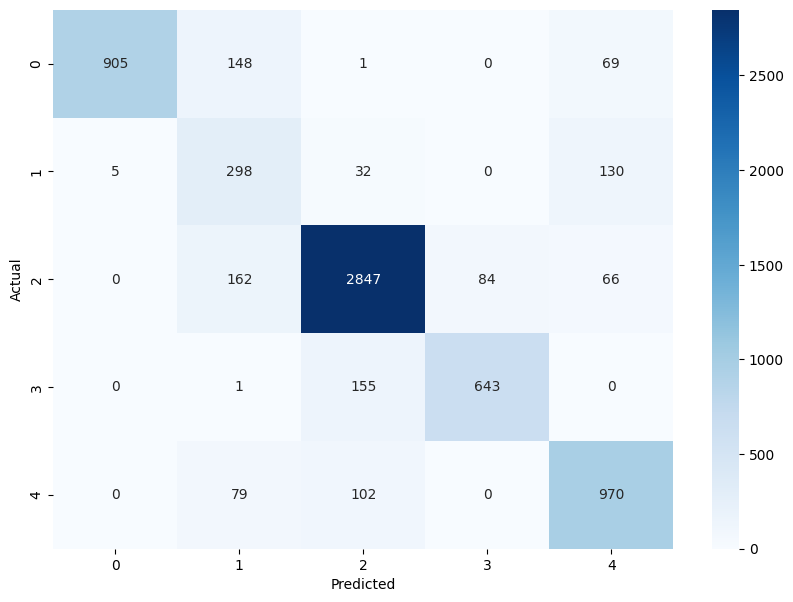

In [62]:
trainer_60s.test()
trainer_60s.plot_confusion_matrix()